<a href="https://colab.research.google.com/github/dav1n9/DAP/blob/main/divorce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get update
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

데이터 설명 : 

이혼한 사람과 이혼하지 않은 사람을 대상으로 인터뷰한 결과를 정리해 놓은 데이터이다.


> *   54개의 질문에 대한 대답이다.
*   각 질문에 대답은 0부터 4로 수집되었다.
> (0=Never, 1=Seldom, 2=Averagely, 3=Frequently, 4=Always)
* 이혼 여부에 대한 정보는 마지막 열에 있다.

[사용한 데이터 : divorce-prediction](https://www.kaggle.com/andrewmvd/divorce-prediction)

# 목표
1. 이혼 예측하기
2. 이혼 예측의 주요 요인 찾기

# 진행 과정
1. 이혼예측
2. 질문 유형 나누기
3. dashboard -> https://github.com/dav1n9/DAP/blob/main/divorce_prediction_dash.ipynb

# 1. 이혼 예측

이혼한 사람과 이혼하지 않은 사람을 대상으로 인터뷰한 결과를 정리한 데이터를 가지고, 이혼 예측 모델을 만들 것입니다.


1.   두 그룹(이혼한 사람/이혼하지 않은 사람)로 나누어서 대답 분포를 살펴본다.
2.   질문에 대한 대답이 들어있는 54개의 열(독립변수)과 이혼 여부가 들어있는 'divorce' 열(종속변수)로 나누어, 이혼을 예측한다.



In [3]:
# 데이터 가져오기
path_divorce = 'https://raw.githubusercontent.com/dav1n9/DAP/main/divorce_data/divorce_data.csv'
df = pd.read_csv(path_divorce,delimiter = ';')
df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Q37,Q38,Q39,Q40,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48,Q49,Q50,Q51,Q52,Q53,Q54,Divorce
0,2,2,4,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,2,1,2,0,1,2,1,3,3,2,1,1,2,3,2,1,3,3,3,2,3,2,1,1
1,4,4,4,4,4,0,0,4,4,4,4,3,4,0,4,4,4,4,3,2,1,1,0,2,2,1,2,0,1,1,0,4,2,3,0,2,3,4,2,4,2,2,3,4,2,2,2,3,4,4,4,4,2,2,1
2,2,2,2,2,1,3,2,1,1,2,3,4,2,3,3,3,3,3,3,2,1,0,1,2,2,2,2,2,3,2,3,3,1,1,1,1,2,1,3,3,3,3,2,3,2,3,2,3,1,1,1,2,2,2,1
3,3,2,3,2,3,3,3,3,3,3,4,3,3,4,3,3,3,3,3,4,1,1,1,1,2,1,1,1,1,3,2,3,2,2,1,1,3,3,4,4,2,2,3,2,3,2,2,3,3,3,3,2,2,2,1
4,2,2,1,1,1,1,0,0,0,0,0,1,0,1,1,1,1,1,2,1,1,0,0,0,0,2,1,2,1,1,1,1,1,1,0,0,0,0,2,1,0,2,3,0,2,2,1,2,3,2,2,2,1,0,1


# (1) 대답 분포 살펴보기(시각화)

[참고](https://www.kaggle.com/alperenclk/for-beginner-divorce-prediction-whit-ann)

클래스 별로 각 질문에 대해서 어떤 대답을 주로 하였는지 Bar그래프로 시각화한다.

(1) df를 divorce가 0인 데이터와 1인 데이터로 나누고,

(2)  각각 0부터 4까지 대답의 빈도를 카운트하여

새로운 데이터 프레임으로 만들었다.


In [4]:
#'divorce'의 값이 1인 행들의 데이터들만 따로 저장
data_married = df.groupby('Divorce').get_group(1)
#'divorce'의 값이 0인 행들의 데이터들만 따로 저장
data_divorced = df.groupby('Divorce').get_group(0)

아래의 코드처럼 값을 카운트하고, 바로 인덱스 기준으로 정렬할 때, 비어있는 값에 대한 문제가 생긴다.

```
d = data_divorced.iloc[:, 31].value_counts().sort_index()
```

예를 들어, 1번 질문에 대해서 0(=Never),이라고 대답한 사람없을 경우, NaN값이 들어간다.

그래서 아래 코드의 if문을 통해, 대답이 없는 경우 값을 추가해준 다음 인덱스 기준으로 정렬한다.

In [5]:
# 이혼하지 않은 경우

res_m = pd.DataFrame([1, 1, 1, 1, 1])

for i in range(len(data_married.columns)-1):
  res_count = data_married.iloc[:, i].value_counts()

  index_check = res_count.index
  if(0 not in index_check):   #'0'을 대답한 사람이 없는 경우 '0'행을 추가하여 0값을 넣어준다.
    res_count[0] = 0
  if(1 not in index_check):
    res_count[1] = 0
  if(2 not in index_check):
    res_count[2] = 0
  if(3 not in index_check):
    res_count[3] = 0
  if(4 not in index_check):
    res_count[4] = 0

  res_count = res_count.sort_index().tolist()     # 행(인덱스) 기준으로 정렬

  res_df = pd.DataFrame(res_count)
  res_m.insert(i, "Q"+str(i+1), res_df, True)

# 해당 대답이 없는 경우 nan값이 들어가 있어서, 0으로 채워줌
res_m = res_m.fillna(0)
res_m = res_m.astype(int)
res_m

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Q37,Q38,Q39,Q40,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48,Q49,Q50,Q51,Q52,Q53,Q54,0
0,1,2,0,2,3,22,29,4,3,2,2,2,2,3,1,2,1,1,2,1,5,7,9,4,5,3,4,6,3,2,2,0,3,2,6,5,1,3,1,1,1,1,2,2,4,4,3,0,0,0,0,0,0,4,1
1,1,2,4,3,5,35,41,3,2,1,2,1,2,2,4,2,2,2,1,4,4,7,4,3,1,3,5,3,5,4,6,5,6,6,7,6,3,3,1,1,2,4,3,2,2,3,6,2,2,4,5,5,6,3,1
2,8,23,15,29,6,22,5,19,13,29,4,18,9,19,11,25,5,16,4,21,17,26,6,21,11,21,17,30,10,22,2,3,4,5,1,2,3,3,5,3,7,6,4,5,7,11,7,5,9,5,5,6,8,7,1
3,45,35,49,32,44,4,4,37,49,34,44,42,44,38,51,35,50,44,50,36,47,29,43,35,43,37,46,28,43,35,17,28,16,25,14,24,16,23,13,23,14,28,19,28,24,23,13,30,17,20,29,16,23,14,1
4,29,22,16,18,26,1,5,21,17,18,32,21,27,22,17,20,26,21,27,22,11,15,22,21,24,20,12,17,23,21,57,48,55,46,56,47,61,52,64,56,60,45,56,47,47,43,55,47,56,55,45,57,47,56,1


질문 1번에 대한 이혼하지 않은 사람들의 대답 분포이다.
* Q1에서 0이라고 대답한 사람/ 1이라고 대답한 사람은 각각 1명, 

* 2라고 대답한 사람 8명, 

* 3이라고 대답한 사람 45명,

* 4라고 대답한 사람 29명

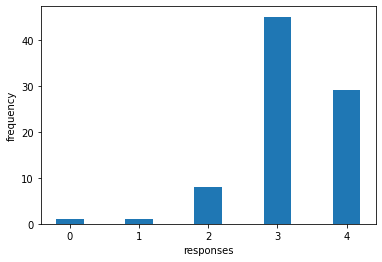

In [6]:
plt.bar(res_m.Q1.index, res_m.Q1, width = 0.4)
plt.xlabel("responses")
plt.ylabel("frequency")
plt.show()

이혼한 사람들의 각 대답을 카운트하여 데이터 프레임을 만든다.(위와 동일한 방법)

In [7]:
# 이혼한 경우

res_d = pd.DataFrame([0, 0, 0, 0, 0])

for i in range(len(data_divorced.columns)-1):
  res_count = data_divorced.iloc[:, i].value_counts()

  index_check = res_count.index
  if(0 not in index_check):   #'0'을 대답한 사람이 없는 경우 '0'행을 추가하여 0값을 넣어준다.
    res_count[0] = 0
  if(1 not in index_check):
    res_count[1] = 0
  if(2 not in index_check):
    res_count[2] = 0
  if(3 not in index_check):
    res_count[3] = 0
  if(4 not in index_check):
    res_count[4] = 0

  res_count = res_count.sort_index().tolist()     # 행(인덱스) 기준으로 정렬

  res_df = pd.DataFrame(res_count)
  res_d.insert(i, "Q"+str(i+1), res_df, True)

# 해당 대답이 없는 경우 nan값이 들어가 있어서, 0으로 채워줌
res_d = res_d.fillna(0)
res_d = res_d.astype(int)
res_d

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Q37,Q38,Q39,Q40,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48,Q49,Q50,Q51,Q52,Q53,Q54,0
0,68,57,51,73,79,64,85,77,81,60,69,56,45,63,68,73,72,78,75,80,73,80,81,68,58,69,73,79,78,70,42,46,68,48,79,83,48,61,49,71,54,43,14,58,24,18,30,10,28,19,12,23,31,46,0
1,8,21,20,9,5,14,1,7,5,17,17,26,31,21,16,12,13,8,10,6,13,6,3,13,27,17,13,7,8,15,22,25,14,31,6,3,28,21,27,12,24,13,16,14,22,15,28,8,26,27,24,23,25,24,0
2,6,5,11,1,2,7,0,2,0,9,0,4,9,2,2,1,1,0,1,0,0,0,2,5,1,0,0,0,0,1,19,9,2,5,0,0,7,3,9,3,7,20,29,12,14,17,13,42,17,31,38,17,18,14,0
3,2,3,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,1,1,0,0,1,0,0,1,6,14,0,12,25,7,20,10,6,9,14,7,1,0
4,2,0,1,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,1,1,0,0,3,0,1,0,0,4,13,2,14,11,8,6,5,3,3,9,5,1,0


질문 1번에 대한 이혼한 사람들의 대답 분포이다.



*   Q1에서 0이라고 대답한 사람 68명
*   1이라고 대답한 사람 8명
*   2라고 대답한 사람 6명
*   3이라고 대답한 사람/ 4라고 대답한 사람 각각 2명



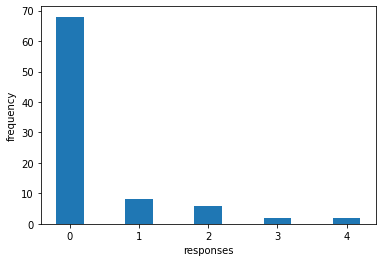

In [8]:
plt.bar(res_d.Q1.index, res_d.Q1, width = 0.4)
plt.xlabel("responses")
plt.ylabel("frequency")
plt.show()

위의 두 그래프를 함께 그려서, 두 클래스의 대답 분포를 비교해 보았다.

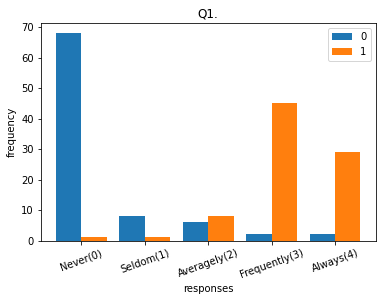

In [9]:
# "Q1" 에 대한 대답
answers = [0, 1, 2, 3, 4]
answers_mean = ['Never(0)', 'Seldom(1)', 'Averagely(2)', 'Frequently(3)', 'Always(4)']
plt.bar(res_d.Q1.index -0.2, res_d.Q1, width = 0.4, label = "0")
plt.bar(res_m.Q1.index +0.2, res_m.Q1, width = 0.4, label = "1")
plt.xlabel("responses")
plt.ylabel("frequency")
plt.title("Q1.")
plt.legend()
plt.xticks(answers, answers_mean, fontsize=10, rotation=20)
plt.show()

나머지 질문들에 대한 대답 분포도 비교해 보았다.
대체로 2를 기준으로, 이혼한 사람들에 대한 그래프는 왼쪽으로 치우쳐있고, 이혼하지 않은 사람들에 대한 그래프는 오른쪽으로 치우쳐 있음을 알 수 있다.

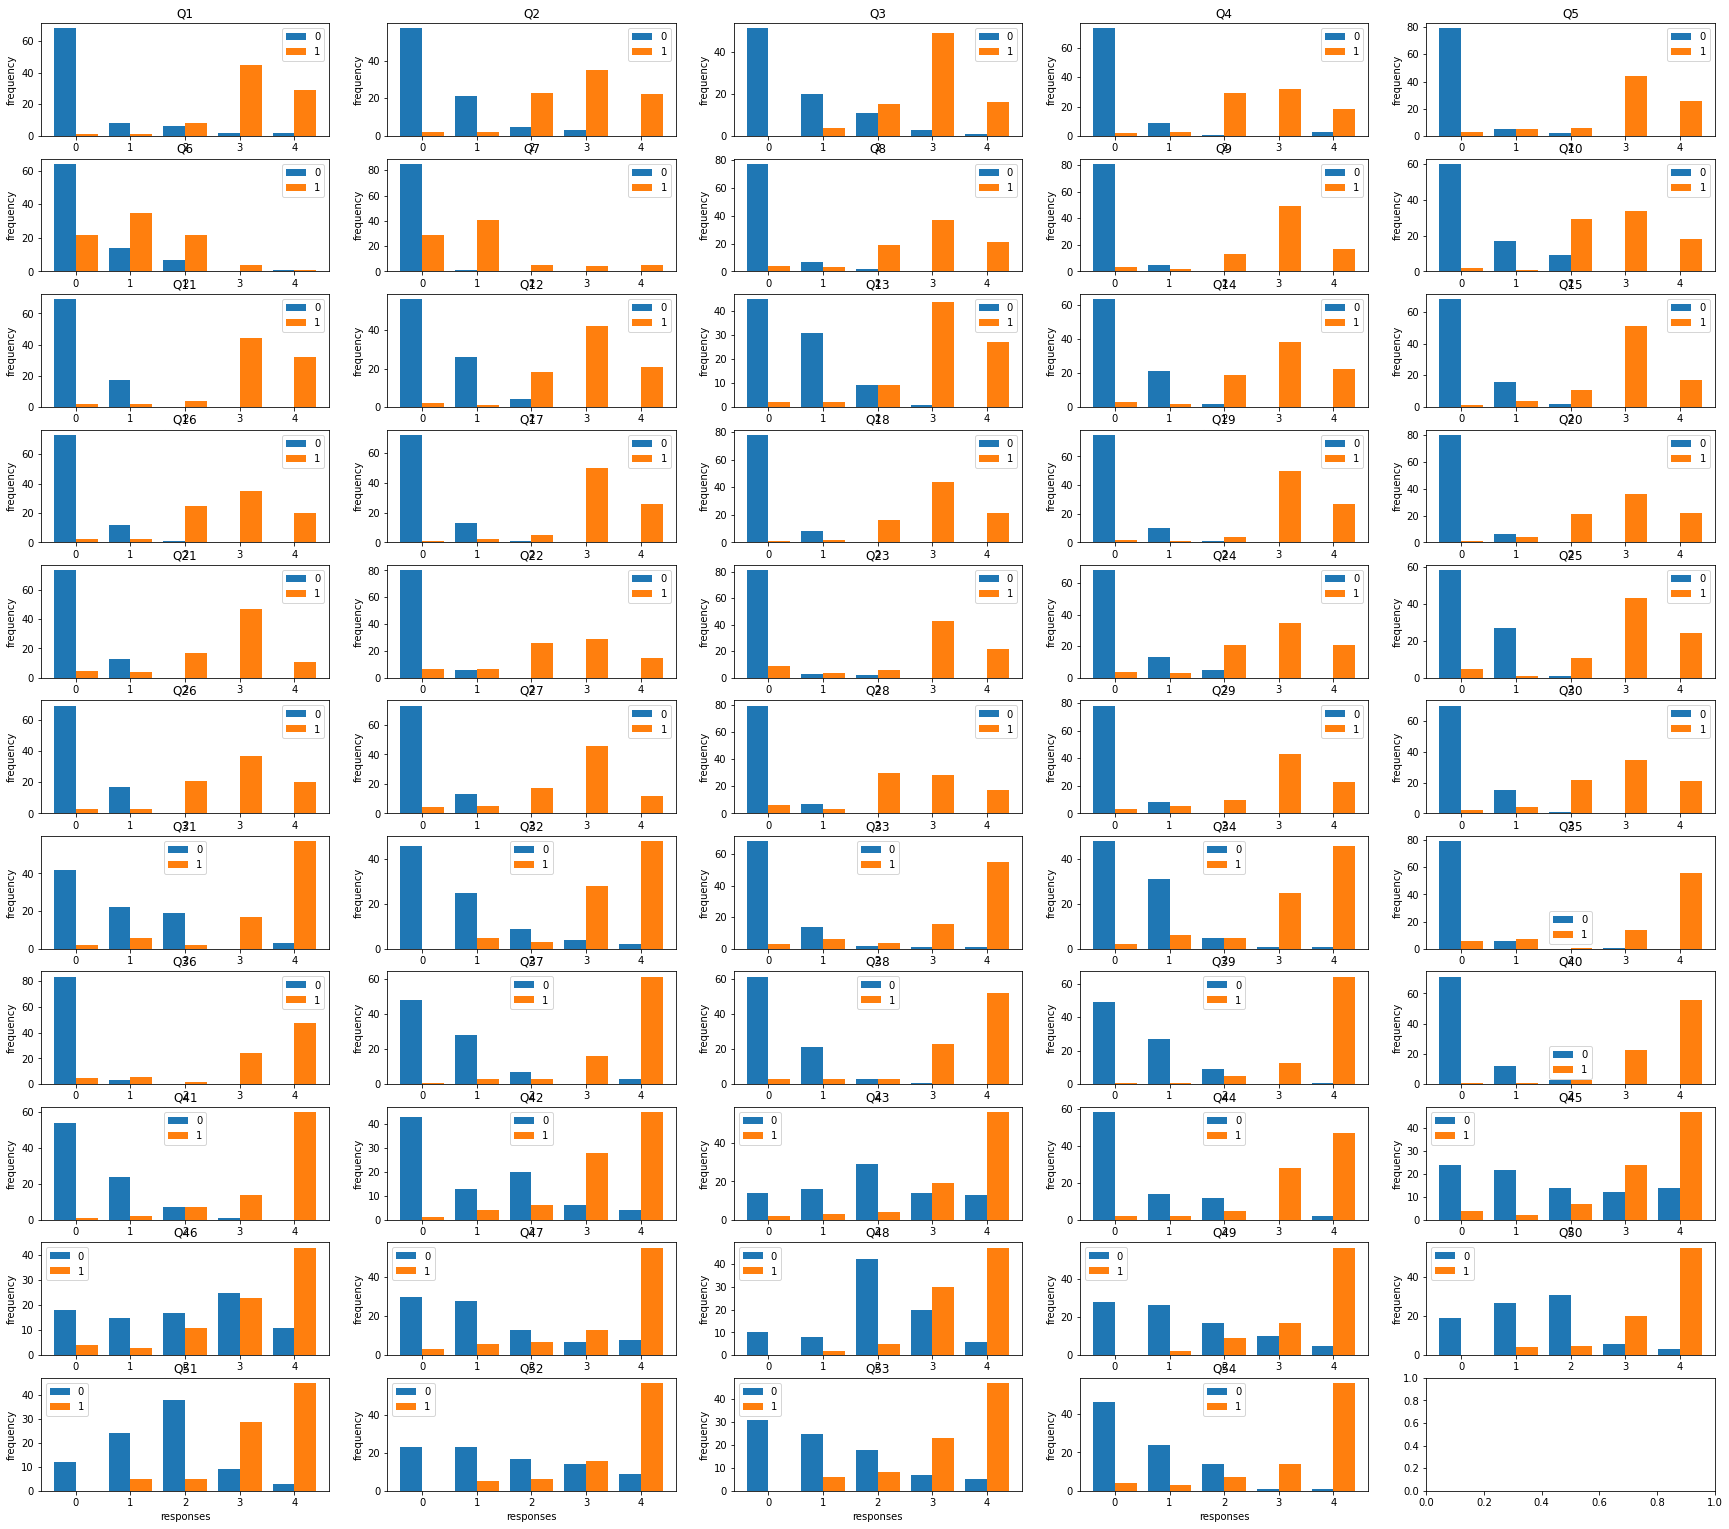

In [10]:
fig,ax=plt.subplots(11, 5, figsize=(30,27))
num_Q = 1
for i in range(0,11):
    for j in range(0,5):
      if num_Q ==55:
            break
      ax[i, j].bar(res_d['Q'+str(num_Q)].index -0.2, res_d['Q'+str(num_Q)], width = 0.4, label = "0")
      ax[i, j].bar(res_m['Q'+str(num_Q)].index +0.2, res_m['Q'+str(num_Q)], width = 0.4, label = "1")
      ax[i, j].set_xlabel("responses")
      ax[i, j].set_ylabel("frequency")
      ax[i, j].set_title("Q" + str(num_Q))
      num_Q += 1
      ax[i, j].legend()
      #ax.xticks(answers, answers_mean, fontsize=10, rotation=20)
plt.show()

# (2) Classification

classification 으로 이혼여부를 예측할 것이다. 아래의 두 방법을 사용한다.

1.   DecisionTree
2.   RandomForest

그리고 특성중요도(feature importance)를 통해 종속변수에 가장 많은 영향을 미치는 독립변수를 찾아본다.




In [11]:
data = df.astype(str)  # str타입으로 바꿈.

In [12]:
from sklearn.model_selection import train_test_split

X = data.drop("Divorce", axis = 1)    # 'Divorce'열을 제외한 나머지
y = data.Divorce

# 데이터 나누기.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

(1) decision tree

decision tree을 통해 모델을 생성하고, 학습 및 예측한다.

In [13]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()      # 모델 생성
dt_clf = dt_clf.fit(X_train, y_train)     # 모델 학습
predictions = dt_clf.predict(X_test)

decision tree 학습 후 특성 중요도를 살펴본다.
- 그래프로 시각화 하였다.
- 10개의 변수까지의 importance값만 받았다. 


In [14]:
dt_clf.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03305556,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.96694444,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

Text(0.5, 0, 'Feature Importances (%)')

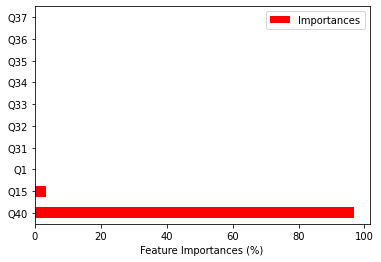

In [15]:
pd.DataFrame(data = dt_clf.feature_importances_*100,
                   columns = ["Importances"],
                   index = X_train.columns).sort_values("Importances", ascending = False)[:10].plot(kind = "barh", color = "r")

plt.xlabel("Feature Importances (%)")

40번 질문의 중요도가 매우 높게 나왔다.

DecisionTree- 성능평가

*   0.92%의 정확도를 가진다.


In [16]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predictions))    # 혼동 행렬( confusion matrix )
print(classification_report(y_test,predictions))    # 성능평가

[[24  3]
 [ 1 23]]
              precision    recall  f1-score   support

           0       0.96      0.89      0.92        27
           1       0.88      0.96      0.92        24

    accuracy                           0.92        51
   macro avg       0.92      0.92      0.92        51
weighted avg       0.92      0.92      0.92        51



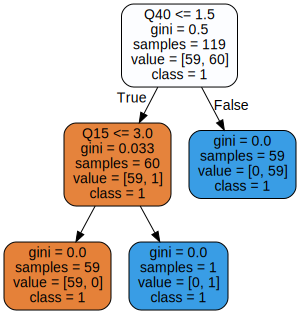

In [17]:
from sklearn.tree import export_graphviz
from graphviz import Source

export_graphviz(dt_clf,                             # 모델
               out_file= "divorce_tree1.dot",  # 저장경로 설정
               feature_names=data.columns[:54],   # 변수명
               class_names=data.Divorce,         # 종속변수
               rounded = True,
               filled = True)

Source.from_file("divorce_tree1.dot")

(2) RandomForest

RandomForest 모델을 생성하고, 학습 및 예측한다.

In [52]:
from sklearn.ensemble import RandomForestClassifier

randomf = RandomForestClassifier()
rf_model = randomf.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

RandomForest 학습 후 얻은 특성 중요도를 그래프로 그려 시각화하였다.

18번이 가장 높고, DecisionTree와 같이 40번이 높게 나왔으며, 그 외에도 17, 11 등의 질문이 높게 나왔다.

Text(0.5, 0, 'Feature Importances (%)')

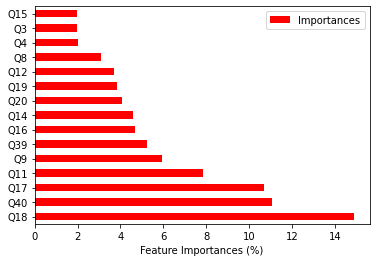

In [53]:
pd.DataFrame(data = rf_model.feature_importances_*100,
                   columns = ["Importances"],
                   index = X_train.columns).sort_values("Importances", ascending = False)[:15].plot(kind = "barh", color = "r")

plt.xlabel("Feature Importances (%)")

RandomForest 성능 평가

In [20]:
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test,rf_predictions))

[[27  0]
 [ 2 22]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       1.00      0.92      0.96        24

    accuracy                           0.96        51
   macro avg       0.97      0.96      0.96        51
weighted avg       0.96      0.96      0.96        51





> 질문 40은?



# 이혼 예측의 결과

(1) 이혼 예측 모델은 각각 0.92%, 0.96%로 높은 정확도를 가집니다.

(2) 특성 중요도를 통해서 40번 질문(+ 20번, 17번)이 가장 많은 영향을 미치는 독립변수임을 알았습니다.

1.   Q17 : 우리는 배우자와 함께 삶의 행복에 대해 **같은 견해를 공유**한다.
2.   Q18 : 배우자와 나는 결혼 생활 방식에 대해 **비슷한 생각**을 가지고 있습니다.
2.   Q40 : 싸움을 시작하기 전에, 무슨 일이 일어나고 있는지 알린다.
    - 싸우기 전에, **대화를 시도**하는지에 대한 질문.

=> (비슷한) 생각이나/ 대화에 대한 질문이 이혼을 예측하는데 중요하다 라고 판단.

# 2. 이혼 예측의 중요 요인 찾기(텍스트 전처리)

!가장 단순하게, 최빈값 사용.

    가장 많은 유형의 질문이 이혼을 예측하는데 중요한 요인이다 라고 가정

(1) 주요 단어 추출하기(질문 요약)

*  54개의 질문들(문장)에서 주요 단어를 추출할 것입니다.
    1.   불용어 제거(NLTK 패키지 활용)
    2.   어간 추출
    3.   길이가 3이하인 단어 삭제
    4.   특정 품사 추출

  https://wikidocs.net/21694

(2) 그 중에서 사용빈도가 높은 단어로 질문 유형 나누기

(3) 가장 많은 비율을 가지는 질문 유형 찾기

목표 : 이혼 예측의 중요 요인 찾기

In [55]:
path_reference = 'https://raw.githubusercontent.com/dav1n9/DAP/main/divorce_data/reference.tsv'
data_reference = pd.read_csv(path_reference, sep = "|", engine='python')

data_reference.head()

,atribute_id,description
0,1,If one of us apologizes when our discussion de...
1,2,"I know we can ignore our differences, even if ..."
2,3,"When we need it, we can take our discussions w..."
3,4,"When I discuss with my spouse, to contact him ..."
4,5,The time I spent with my wife is special for us.


In [56]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# (1) 주요 단어 찾기

1) 어간 추출

> 섬세한 작업이 아니기 때문에 사전에 존재하지 않는 단어가 나올 수 있다.


---

 => 일반동사들이나 명사 뒤에 e나 s가 삭제되는 경우 많음. 
 그러나 어간 추출을 하지 않으면 같은 의미를 가진 단어들이 많이 중복됨.(요약 불가)

 ex. dicuss , discussion, discussions 이런식임.
 그래서 일단 어간 추출 단계를 포함함.




In [57]:
for i in range(0, 54):
    clean_words = []
    document = data_reference.description[i]
    for word in nltk.tokenize.word_tokenize(document):  #공백과 구두점(punctuation: ,혹은 .)을 기준으로 단어 분리, 축약형 단어도 분리 (Can't ==> ['Ca', "n't"])
        word = word.lower() # 소문자로.
        stemmer = nltk.stem.snowball.SnowballStemmer('english')
        word = stemmer.stem(word) #어간 추출
        clean_words.append(word)
    print(clean_words) # 추출된 어간들
    document = ' '.join(clean_words)          # 추출된 어간들 다시 묶어서
    data_reference.description[i] = document  # data_reference에 저장.


['if', 'one', 'of', 'us', 'apolog', 'when', 'our', 'discuss', 'deterior', ',', 'the', 'discuss', 'end', '.']
['i', 'know', 'we', 'can', 'ignor', 'our', 'differ', ',', 'even', 'if', 'thing', 'get', 'hard', 'sometim', '.']
['when', 'we', 'need', 'it', ',', 'we', 'can', 'take', 'our', 'discuss', 'with', 'my', 'spous', 'from', 'the', 'begin', 'and', 'correct', 'it', '.']
['when', 'i', 'discuss', 'with', 'my', 'spous', ',', 'to', 'contact', 'him', 'will', 'eventu', 'work', '.']
['the', 'time', 'i', 'spent', 'with', 'my', 'wife', 'is', 'special', 'for', 'us', '.']
['we', 'do', "n't", 'have', 'time', 'at', 'home', 'as', 'partner', '.']
['we', 'are', 'like', 'two', 'stranger', 'who', 'share', 'the', 'same', 'environ', 'at', 'home', 'rather', 'than', 'famili', '.']
['i', 'enjoy', 'our', 'holiday', 'with', 'my', 'wife', '.']
['i', 'enjoy', 'travel', 'with', 'my', 'wife', '.']
['most', 'of', 'our', 'goal', 'are', 'common', 'to', 'my', 'spous', '.']
['i', 'think', 'that', 'one', 'day', 'in', 'the'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:
data_reference.head()

,atribute_id,description
0,1,if one of us apolog when our discuss deterior ...
1,2,"i know we can ignor our differ , even if thing..."
2,3,"when we need it , we can take our discuss with..."
3,4,"when i discuss with my spous , to contact him ..."
4,5,the time i spent with my wife is special for us .


2) 불용어 삭제

> 자주 등장하지만 분석을 하는 것에 있어서는 큰 도움이 되지 않는 단어를 불용어라고 한다. ex. 'i', 'me', 'my'

불용어를 삭제하지 않고, 가장 많이 사용된 단어를 추출하면, 'i', 'we', 'my' 같은 의미없는 단어들이 결과값으로 나온다.

그래서 불용어를 삭제해준다.

In [59]:
from nltk.corpus import stopwords
# 불용어 예시
print(stopwords.words('english')[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [60]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('english'))

for i in range(0, 54):
  result = []
  st = data_reference.description[i]
  # 공백과 구두점(punctuation: ,혹은 .)을 기준으로 단어 분리, 축약형 단어도 분리 (Can't ==> ['Ca', "n't"])
  for word in word_tokenize(st):
    word = word.lower()
    if word not in stopwords.words('english'): #불용어 제거
      result.append(word)
  print(result)  # 추출된 어간들
  st = ' '.join(result)
  data_reference.description[i] = st


['one', 'us', 'apolog', 'discuss', 'deterior', ',', 'discuss', 'end', '.']
['know', 'ignor', 'differ', ',', 'even', 'thing', 'get', 'hard', 'sometim', '.']
['need', ',', 'take', 'discuss', 'spous', 'begin', 'correct', '.']
['discuss', 'spous', ',', 'contact', 'eventu', 'work', '.']
['time', 'spent', 'wife', 'special', 'us', '.']
["n't", 'time', 'home', 'partner', '.']
['like', 'two', 'stranger', 'share', 'environ', 'home', 'rather', 'famili', '.']
['enjoy', 'holiday', 'wife', '.']
['enjoy', 'travel', 'wife', '.']
['goal', 'common', 'spous', '.']
['think', 'one', 'day', 'futur', ',', 'look', 'back', ',', 'see', 'spous', 'harmoni', '.']
['spous', 'similar', 'valu', 'term', 'person', 'freedom', '.']
['spous', 'similar', 'sens', 'entertain', '.']
['goal', 'peopl', '(', 'children', ',', 'friend', ',', 'etc', '.', ')', '.']
['dream', 'spous', 'similar', 'harmoni', '.']
['compat', 'spous', 'love', '.']
['share', 'view', 'happi', 'life', 'spous']
['spous', 'similar', 'idea', 'marriag']
['spous

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



['discuss', ',', 'remind', 'spous', 'her/hi', 'inadequaci', '.']
["'m", 'afraid', 'tell', 'spous', 'her/hi', 'incompet', '.']


In [61]:
data_reference.head()

,atribute_id,description
0,1,"one us apolog discuss deterior , discuss end ."
1,2,"know ignor differ , even thing get hard sometim ."
2,3,"need , take discuss spous begin correct ."
3,4,"discuss spous , contact eventu work ."
4,5,time spent wife special us .




---
3) 길이가 짧은 단어 삭제

아포스트로피를 기준으로 나뉘면서 생기는 단어들 (ex. 's / n't) 을 지워주기 위해 길이가 짧은 단어는 삭제하였다.
  
*  글자의 길이가 3이하인 단어 삭제.


In [62]:
for i in range(0, 54):
    clean_words = []
    document = data_reference.description[i]
    for word in nltk.tokenize.word_tokenize(document):  #공백과 구두점(punctuation: ,혹은 .)을 기준으로 단어 분리, 축약형 단어도 분리 (Can't ==> ['Ca', "n't"])
        word = word.lower() # 소문자로.
        if len(word) > 3:
          clean_words.append(word)
    #print(clean_words) #  추출된 어간들
    document = ' '.join(clean_words)
    #print(document) #  추출된 어간들 다시 묶어서
    data_reference.description[i] = document # data_reference에 저장.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [63]:
data_reference.head()

,atribute_id,description
0,1,apolog discuss deterior discuss
1,2,know ignor differ even thing hard sometim
2,3,need take discuss spous begin correct
3,4,discuss spous contact eventu work
4,5,time spent wife special



> 무조건 단어 길이로 단어의 의미를 판단하는 건 좋은 방법 아님


3이하인 단어 삭제하면서 'use', 'see', 'say' 와 같은 의미있는 단어들 삭제되지만, 사용빈도가 높지않고, 크게 중요한 단어 아니므로 삭제한다



4) 품사 태깅

> ex. VBP = 동사, RB = 부사, VBG = 현재부사, IN = 전치사, NPP = 고유명사, NNS = 복수형 명사, CC = 접속사, DT = 관사


조금 더 의미있는 단어들만 남기기 위해, 명사/ 동사/ 형용사만 가져온다.

In [66]:
from nltk.tag import pos_tag

#텍스트 정제 (형태소 분석)
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
for i in range(0, 54):
    clean_words = []
    document = data_reference.description[i]

    for word in pos_tag(nltk.tokenize.word_tokenize(document)):
        if word[1] in ['NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS']: #명사, 동사, 형용사
            clean_words.append(word[0].lower())

    #print(clean_words) #['stale', 'uninspired']
    document = ' '.join(clean_words)
    print(document) #stale uninspired
    data_reference.description[i] = document


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
apolog discuss deterior discuss
know ignor differ thing hard sometim
take spous begin correct
spous contact eventu work
time spent wife special
time home partner
stranger share environ home famili
enjoy holiday wife
enjoy travel wife
goal common spous
think futur look spous harmoni
spous similar valu term person freedom
spous similar sens entertain
goal peopl children friend
dream spous similar harmoni
spous love
share view happi life spous
spous similar idea marriag
spous similar idea role marriag
spous similar valu trust
know exact wife
know spous want taken care she/h sick
spous favorit food
tell kind stress spous face her/hi life
spous inner world
know spous basic anxieti
spous current so

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [67]:
data_reference.head()

,atribute_id,description
0,1,apolog discuss deterior discuss
1,2,know ignor differ thing hard sometim
2,3,take spous begin correct
3,4,spous contact eventu work
4,5,time spent wife special


# (2) 등장 빈도 높은 단어 추출

위의 텍스트 전처리 과정으로 54개의 질문들을 각각 2~7개의 의미있는 단어로 요약하였다. 

그 중에서 등장 빈도가 높은 단어를 추출할 것이다.

*  단어들을 하나의 배열에 담고 단어 사용 빈도 수를 살펴본다.

*  위에서 사용한 품사 태깅 방법으로 3개의 배열(명사, 동사, 형용사)로 단어를 나누어, 각각 빈도수가 높은 단어 10개씩 추출한다.

In [32]:
# 단어들 하나의 배열에 담기

words = []
for i in range(0, 54):
    document = data_reference.description[i]
    for word in nltk.tokenize.word_tokenize(document):  # 단어로 분리
          words.append(word)

print(words)

['apolog', 'discuss', 'deterior', 'discuss', 'know', 'ignor', 'differ', 'thing', 'hard', 'sometim', 'take', 'spous', 'begin', 'correct', 'spous', 'contact', 'eventu', 'work', 'time', 'spent', 'wife', 'special', 'time', 'home', 'partner', 'stranger', 'share', 'environ', 'home', 'famili', 'enjoy', 'holiday', 'wife', 'enjoy', 'travel', 'wife', 'goal', 'common', 'spous', 'think', 'futur', 'look', 'spous', 'harmoni', 'spous', 'similar', 'valu', 'term', 'person', 'freedom', 'spous', 'similar', 'sens', 'entertain', 'goal', 'peopl', 'children', 'friend', 'dream', 'spous', 'similar', 'harmoni', 'spous', 'love', 'share', 'view', 'happi', 'life', 'spous', 'spous', 'similar', 'idea', 'marriag', 'spous', 'similar', 'idea', 'role', 'marriag', 'spous', 'similar', 'valu', 'trust', 'know', 'exact', 'wife', 'know', 'spous', 'want', 'taken', 'care', 'she/h', 'sick', 'spous', 'favorit', 'food', 'tell', 'kind', 'stress', 'spous', 'face', 'her/hi', 'life', 'spous', 'inner', 'world', 'know', 'spous', 'basic'

In [33]:
# 단어들을 명사, 동사, 형용사로 나누어 줌

noun = []
verb = []
adj = []

tag = pos_tag(words)    # words에 들어있는 단어들을 ('단어', '품사') 형태로 저장
                        # 그래서 tag[i][1]은 품사, tag[i][0]은 단어가 되는 것.

for i in range(0, len(tag)):
  if tag[i][1] in ['NN', 'NNS', 'NNP', 'NNPS']: 
    noun.append(tag[i][0])
  elif tag[i][1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
    verb.append(tag[i][0])
  elif tag[i][1] in ['JJ', 'JJR', 'JJS']:
    adj.append(tag[i][0])

# 명사, 동사, 형용사만 뽑았는데,, 잘못 분류된것도 있는듯.
print(noun)
print(verb)
print(adj)

['apolog', 'discuss', 'discuss', 'ignor', 'thing', 'sometim', 'begin', 'contact', 'eventu', 'work', 'time', 'wife', 'time', 'home', 'partner', 'stranger', 'share', 'home', 'famili', 'enjoy', 'wife', 'wife', 'goal', 'harmoni', 'valu', 'term', 'person', 'sens', 'goal', 'peopl', 'children', 'dream', 'harmoni', 'love', 'share', 'view', 'life', 'idea', 'idea', 'role', 'valu', 'trust', 'wife', 'care', 'favorit', 'food', 'tell', 'kind', 'stress', 'face', 'life', 'world', 'anxieti', 'sourc', 'stress', 'hope', 'veri', 'relationship', 'express', 'statement', 'person', 'dure', 'discuss', 'dure', 'discuss', 'insult', 'dure', 'discuss', 'humili', 'calm', 'subject', 'discuss', 'start', 'discuss', 'befor', 'talk', 'someth', 'calm', 'onli', 'word', 'stay', 'calm', 'environ', 'littl', 'sometim', 'leav', 'home', 'stay', 'discuss', 'right', 'discuss', 'hurt', 'stay', 'becaus', 'control', 'anger', 'discuss', 'guilti', 'accus', 'problem', 'home', 'hesit', 'her/hi', 'inadequaci', 'discuss', 'her/hi', 'inade

(단어, 사용빈도) 의 형태로 출력됨

In [34]:
# 명사, 동사, 형용사 단어들의 빈도수 세기

import collections

# 각각 빈도수가 높은 10개만 출력
counts_noun = collections.Counter(noun)
print(counts_noun.most_common(10))

counts_verb = collections.Counter(verb)
print(counts_verb.most_common(10))

counts_adj = collections.Counter(adj)
print(counts_adj.most_common(10))

[('discuss', 11), ('wife', 4), ('home', 4), ('dure', 3), ('calm', 3), ('stay', 3), ('her/hi', 3), ('sometim', 2), ('time', 2), ('share', 2)]
[('know', 5), ('think', 2), ('friend', 2), ('feel', 2), ('differ', 1), ('take', 1), ('correct', 1), ('environ', 1), ('enjoy', 1), ('look', 1)]
[('spous', 35), ('similar', 6), ('silent', 4), ('afraid', 2), ('deterior', 1), ('hard', 1), ('spent', 1), ('special', 1), ('holiday', 1), ('travel', 1)]


# (2)-2 빈도 수 높은 단어 시각화


---

단어 빈도 수에 대한 그래프
*  명사, 동사, 형용사가 담긴 배열을 합하고, 사용빈도가 높은 단어 20개를 그래프로 
나타내었다.

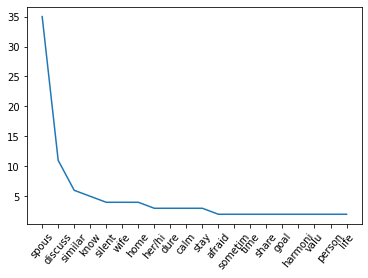

In [35]:
all_words = counts_adj | counts_noun | counts_verb    # 합집합
all_words = all_words.most_common(20)

df_words_count = pd.DataFrame(all_words)

plt.plot(df_words_count[0], df_words_count[1])
plt.xticks(df_words_count[0], fontsize=10, rotation= 50)
plt.show()

In [36]:
df_words_count.to_csv('df_words_count.csv')  # df_words_count는 따로 csv파일로 저장해줌. 대시보드 만들때 다시 불러올 것.

위의 그래프보다 한 눈에 파악하기 쉽도록 워드 클라우드 만들었다.



*   워드 클라우드



아래는 명사, 동사, 형용사에 대한 각각의 워드 클라우드이다.

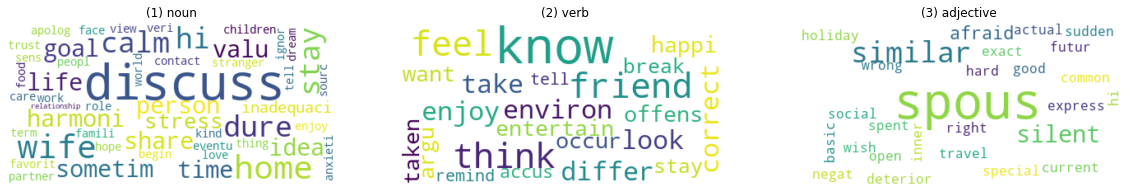

In [37]:
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from os import path

# + verb + adj

n_words = noun
v_words = verb
a_words = adj

noun_text = ''
verb_text = ''
adj_text = ''
for word in n_words:
    noun_text = noun_text +' '+word
for word in v_words:
    verb_text = verb_text +' '+word
for word in a_words:
    adj_text = adj_text +' '+word

wordcloud_n = WordCloud(max_font_size=60, relative_scaling=.5, background_color='white', max_words=50).generate(noun_text) # generate() 는 하나의 string value를 입력 받음
wordcloud_v = WordCloud(max_font_size=60, relative_scaling=.5, background_color='white', max_words=50).generate(verb_text)
wordcloud_a = WordCloud(max_font_size=60, relative_scaling=.5, background_color='white', max_words=50).generate(adj_text)

fig = plt.figure()
#plt.figure(figsize = (20, 10))
rows = 1
cols = 3

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(wordcloud_n, interpolation='bilinear')
ax1.set_title('(1) noun')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(wordcloud_v, interpolation='bilinear')
ax2.set_title('(2) verb')
ax2.axis("off")
 
ax3 = fig.add_subplot(rows, cols, 3)
ax3.imshow(wordcloud_a, interpolation='bilinear')
ax3.set_title('(3) adjective')
ax3.axis("off")

fig.set_size_inches(20, 10)
#plt.imshow(wordcloud_n, interpolation='bilinear')
#plt.imshow(wordcloud_v, interpolation='bilinear')
#plt.imshow(wordcloud_a, interpolation='bilinear')
#plt.axis("off")
plt.show()

!data_reference 질문 유형

위의 단어들 중에서 빈도 수가 가장 많은 단어 기준으로 질문 유형 파악하기.

빈도 수가 가장 높은 단어 :

> *   ('discuss', 11), ('wife', 4)
*   ('know', 5), ('think', 2)
*   ('spous', 35), ('similar', 6)

빈도 수가 높은 단어를 조합하여, 질문의 유형을 나눠본다.

+ 배우자와의 대화, 배우자를 잘 아는 것, 비슷한 무언가(비슷한 생각이나 목표가 될 수 있을 듯) 등으로 위의 단어를 조합할 수 있다.


In [38]:
data_reference_keywords  = pd.read_csv(path_reference, sep = "|", engine='python')

# (3) 질문 유형 나누기

빈도 수가 가장 높은 단어와 비슷한 의미를 가지는 단어를 조합하여 5개의 질문 유형을 정하였다.

* discussion / tell / share
* know + spouse
* spent/enjoy + time
* similar
* silent/calm

---
1. 대화
2. 서로를 잘 아는 것
3. 함께하기
4. 공통점
5. 그 외..

위의 다섯가지로 질문들을 분류해보자.

findall함수에 주어진 패턴에 매칭되는 단어가 각 질문에 포함되어있는지 if문을 통해 확인한다.

만약 1번 유형과 관련있는 단어가 들어있다면, 그 질문의 type을 1로 설정한다.

In [39]:
import re

data_reference_clf = []

for i in range(0, 54):
    keywords = []
    document = data_reference_keywords.description[i]
    # 1번 : 대화
    if(re.findall(r'\bdiscus\w+', document) or re.findall(r'\btel\w+', document) or re.findall(r'\bshar\w+', document) or re.findall(r'\btal\w+', document)):
      data_reference_clf.append('1')
    # 2번 : (배우자를) 잘 아는 것
    elif(re.findall(r'\bkno\w+', document)):
      data_reference_clf.append('2')
    # 3번 : 시간보내기
    elif(re.findall(r'\bspen\w+', document) or re.findall(r'\benjo\w+', document) or re.findall(r'\btim\w+', document)) :
      data_reference_clf.append('3')
    # 4번 : 비슷한 생각/목표 등
    elif(re.findall(r'\bsimil\w+', document) or re.findall(r'\bgoal\w+', document) or re.findall(r'\bcommo\w+', document)) :
      data_reference_clf.append('4')
    # 5번 : 그 외..
    else:
      data_reference_clf.append('5')
    
print(data_reference_clf)

['1', '2', '1', '1', '3', '3', '1', '3', '3', '4', '5', '4', '4', '4', '4', '5', '1', '4', '4', '4', '2', '2', '2', '1', '2', '2', '2', '2', '2', '2', '5', '1', '1', '1', '1', '5', '1', '5', '1', '1', '1', '5', '5', '5', '1', '1', '1', '1', '5', '5', '5', '1', '1', '1']


위에서 설정한 type을 data_reference의 새로운 열로 추가한다.(열 이름 'type')

In [40]:
data_reference_keywords['type'] = data_reference_clf
data_reference_keywords.head()

,atribute_id,description,type
0,1,If one of us apologizes when our discussion de...,1
1,2,"I know we can ignore our differences, even if ...",2
2,3,"When we need it, we can take our discussions w...",1
3,4,"When I discuss with my spouse, to contact him ...",1
4,5,The time I spent with my wife is special for us.,3


---------

In [41]:
data_reference_keywords['keywords'] = data_reference_keywords.description
for i in range(0, 54):
    keywords = []
    document = data_reference_keywords.description[i]
    for word in nltk.tokenize.word_tokenize(document):  #공백과 구두점(punctuation: ,혹은 .)을 기준으로 단어 분리, 축약형 단어도 분리 (Can't ==> ['Ca', "n't"])
        word = word.lower() # 소문자로.
        if word in ['discuss', 'discussion', 'discussions', "discussing", 'tell', 'share', 'talk',
                    'know', 
                    'similar', 'goals', 'common',
                    'enjoy', 'spent', 'spend', 'time']:
          keywords.append(word)
    document = ' '.join(keywords)
    if (keywords == []):
      document = 'etc.'
  
    data_reference_keywords.keywords[i] = document # data_reference에 저장.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


같은 방법으로 질문 유형과 관련있는 키워드가 들어있는지 확인 후, 키워드에 대한 새로운 열을 추가한다.

In [42]:
data_reference_keywords.head()

,atribute_id,description,type,keywords
0,1,If one of us apologizes when our discussion de...,1,discussion discussion
1,2,"I know we can ignore our differences, even if ...",2,know
2,3,"When we need it, we can take our discussions w...",1,discussions
3,4,"When I discuss with my spouse, to contact him ...",1,discuss
4,5,The time I spent with my wife is special for us.,3,time spent


질문의 유형을 1부터 5까지 번호로 나누어봤다.

이제, 어떤 질문 유형이 가장 많은지 살펴보기 위해, 같은 유형끼리 묶어서 카운트해준다.

In [43]:
# type이 같은 것끼리 묶어서 카운트해준 값을 (인덱스 기준)정렬하여 저장
df_type = data_reference_keywords.type.value_counts().sort_index()
df_type

1    21
2    10
3     4
4     8
5    11
Name: type, dtype: int64

In [44]:
df_type.to_csv('df_type.csv')  # df_type은 따로 csv파일로 저장해줌. 대시보드 만들때 다시 불러올 것.

파이차트로 시각화

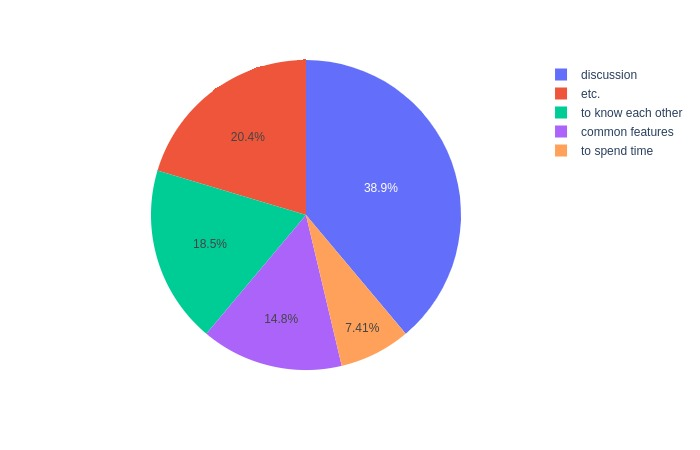

In [45]:
import plotly.express as px
labels = ['discussion', 'to know each other', 'to spend time', 'common features', 'etc.']
fig = px.pie(df_type,labels, values='type')
fig.show("jpg")

38.9% 로 대화 관련 질문이 가장 많은 것을 확인했다.

이혼을 예측할 때 대화 관련 질문이 가장 많다는 것을 의미하며,
부부관계에서 대화가 중요하다고 할 수 있을 것이다.

# 정리

(1) 이혼 예측
- decision tree, random forest 방법으로 0.92%, 0.96%의 높은 정확도를 가진 예측 모델을 만들었다.
- 특성중요도를 통해 대화, 비슷한 결혼 생활에 대한 질문이 이혼을 예측하는데 중요한 요인임을 알 수 있었다.


(2) 이혼 예측의 중요 요인
- 텍스트 전처리를 통해 질문을 요약하였고, 빈도 수가 높은 단어로 질문 유형을 나누었다.
- '대화' 관련 질문이 가장 많은 비율을 차지한다는 사실을 통해, '대화' 관련 질문이 이혼을 예측하는데 주요한 질문 유형임을 알 수 있었다.

# 3. Dashboard

# 새로운 노트에서 구현함 :
# [divorce_prediction_dash](https://github.com/dav1n9/DAP/blob/main/divorce_prediction_dash.ipynb)

divorce_prediction을 진행하면서 시각화했던 그래프들로 간단한 대시보드를 만들었다.

1. 그래프 정보

  3개의 탭으로 구분하였고, 각 탭에서 아래의 정보를 담은 그래프를 볼 수 있다.

      *  (1) 54개의 대답에 대한 **두 그룹의 대답 분포** -> 바그래프
      *  (2) **가장 많이 사용된 주요 단어** (0개~20까지) -> 라인그래프
      *  (3) **대답 유형별 비율** -> 파이차트


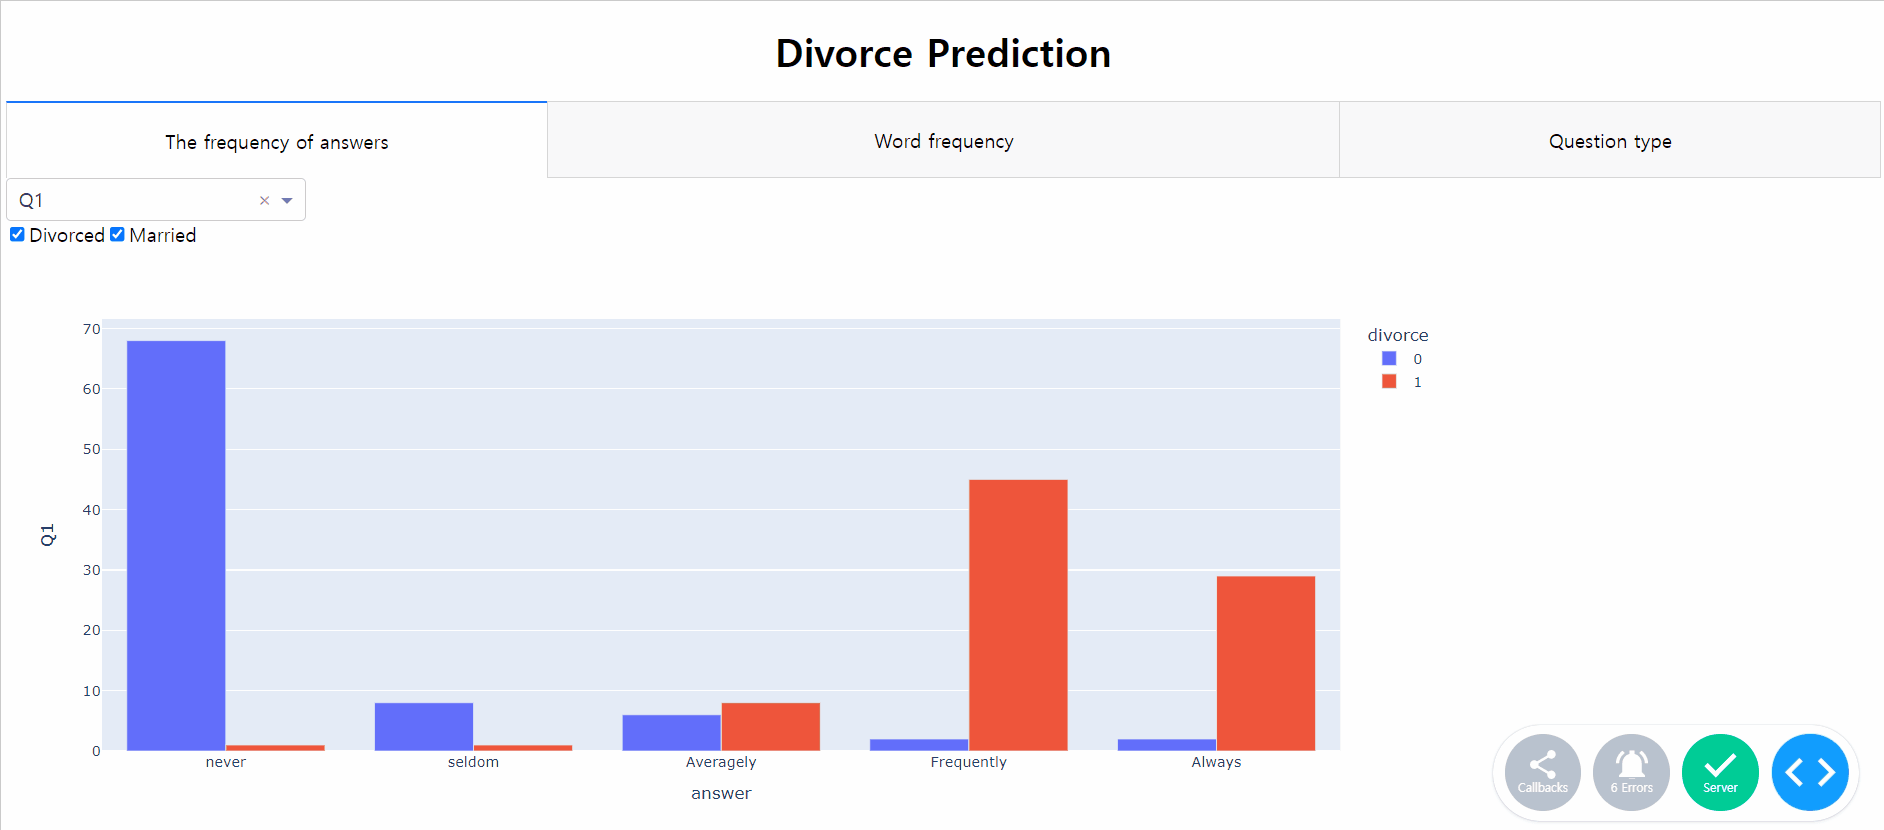



2. input values

  * 첫번째 바 그래프 : Dropdown으로 **질문선택**과 checkbox로 **그룹 선택**이 가능하다.

  * 두번째 라인 그래프 : 사용빈도를 확인할 **단어 수를 입력**할 수 있다.(0부터 20까지의 숫자를 입력)

  * 세번째 파이차트 : Dropdown으로 원하는 **질문 타입을 선택**할 수 있고, 복수 선택이 가능하다.


위에서 시각화했던 3개의 그래프들을 가지고 대시보드를 구현하였다.

(plotly로 재구현 - 재구현 과정은 아래에 있음)

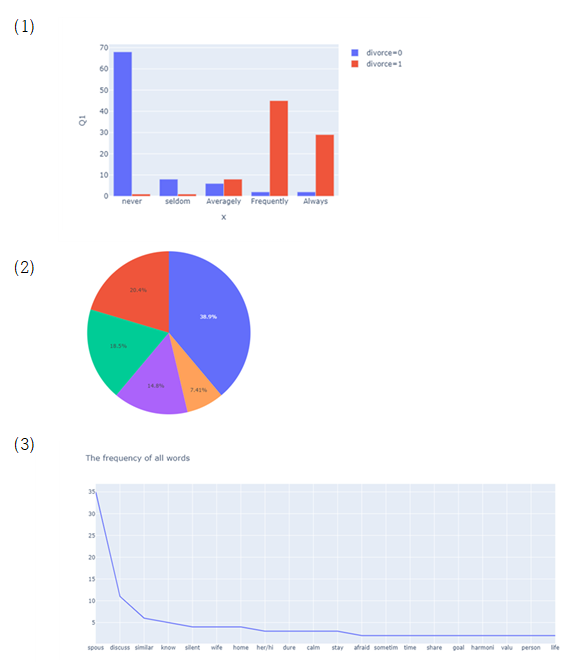

# plotly 이용하여 그래프 재구현

In [46]:
df_sum = pd.concat([res_d, res_m])

df_sum = df_sum.rename(columns={0 : "divorce"})
df_sum = df_sum.rename(index={0 : "never", 
                              1 : "seldom", 
                              2 :'Averagely', 
                              3 : 'Frequently',
                              4 : 'Always'})
# 여기서 'divorce'열을 스트링 타입으로 바꿔준 이유 (스트링으로 바꾸면서 두문제 해결)
# 1. bar그래프 그릴때 divorce기준으로 구분하는데 0과1이 아니라 0부터 1로 색깔 구분이 됨.
# 2. divorce기준으로 구분된 두 그래프가 겹쳐져서 그려짐.
df_sum['divorce'] = df_sum['divorce'].astype(str)

print(df_sum)

            Q1  Q2  Q3  Q4  Q5  Q6  Q7  ...  Q49  Q50  Q51  Q52  Q53  Q54  divorce
never       68  57  51  73  79  64  85  ...   28   19   12   23   31   46        0
seldom       8  21  20   9   5  14   1  ...   26   27   24   23   25   24        0
Averagely    6   5  11   1   2   7   0  ...   17   31   38   17   18   14        0
Frequently   2   3   3   0   0   0   0  ...   10    6    9   14    7    1        0
Always       2   0   1   3   0   1   0  ...    5    3    3    9    5    1        0
never        1   2   0   2   3  22  29  ...    0    0    0    0    0    4        1
seldom       1   2   4   3   5  35  41  ...    2    4    5    5    6    3        1
Averagely    8  23  15  29   6  22   5  ...    9    5    5    6    8    7        1
Frequently  45  35  49  32  44   4   4  ...   17   20   29   16   23   14        1
Always      29  22  16  18  26   1   5  ...   56   55   45   57   47   56        1

[10 rows x 55 columns]


In [47]:
df_sum.to_csv('divorce_sum.csv')  # 따로 csv파일로 저장해줌. 대시보드 만들때 사용

(1) 각 질문에 대한 두 그룹의 대답 분포

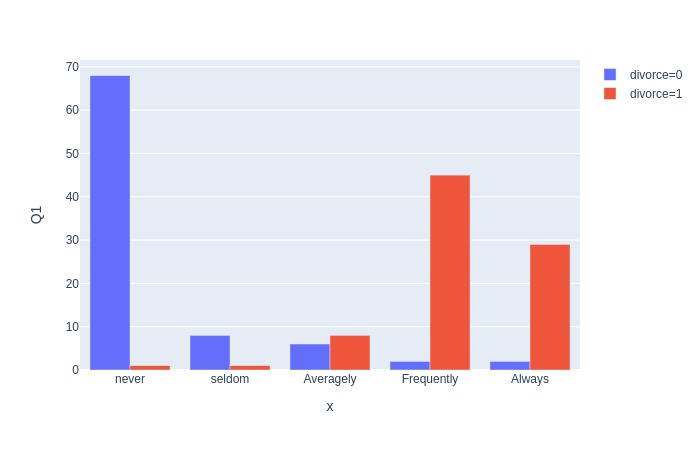

In [48]:
import plotly.express as px
fig = px.bar(df_sum, x=df_sum.index, y=df_sum["Q1"], color='divorce', barmode='group',width=600, height=400)
fig.update_xaxes(type='category')

fig.show('jpg')



(2) 단어 빈도수를 나타내는 라인 그래프

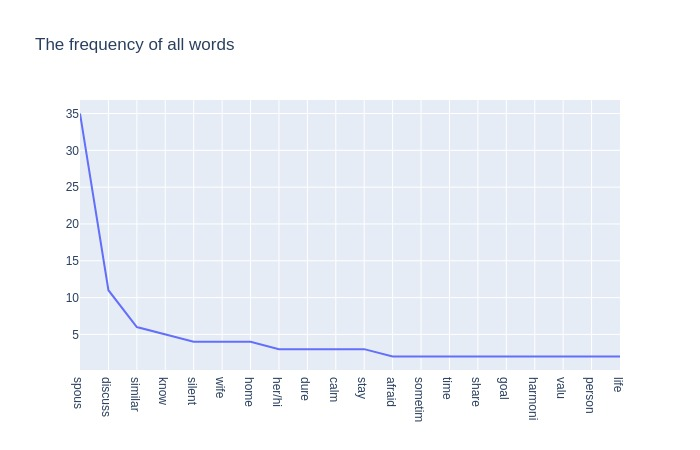

In [49]:
import plotly.graph_objects as go

import pandas as pd
all_words = counts_adj | counts_noun | counts_verb    # 합집합
all_words = all_words.most_common(20)
df_words_count = pd.DataFrame(all_words)
fig = go.Figure(go.Scatter(
    x = df_words_count[0],
    y = df_words_count[1],
))

fig.update_layout(title = 'The frequency of all words')

fig.show('jpg')